## 5. Análise Exploratória dos Dados

In [30]:
import pandas as pd

# data_folder = "../data/cleaned_data.csv"
data_folder = '../data/df_18-20.csv'

# Carregando dados limpos (resultado da Pré-Tokenização)
df_enem = pd.read_csv(data_folder)
df_enem.head()

,CO_POSICAO,TX_GABARITO,NU_PARAM_A,NU_PARAM_B,NU_PARAM_C,ANO,QUESTOES,ALTERNATIVAS
0,46,C,5.10044,1.51100,0.13957,2018,No Segundo Congresso Internacional de Ciências...,A: preservação cultural dos territórios ocupad...
1,47,A,3.21792,1.65990,0.14834,2018,A existência em Jerusalém de um hospital volta...,"A: surgimento do monasticismo guerreiro, ocasi..."
2,48,C,3.46765,1.30736,0.15603,2018,"A tribo não possui um rei, mas um chefe que nã...",A: Imposição ideológica e normas hierárquicas;...
3,49,D,2.67992,1.47683,0.11389,2018,O filósofo reconhece-se pela posse inseparável...,A: reunir os antagonismos das opiniões ao méto...
4,50,D,4.00369,1.39940,0.16074,2018,Figura 1Disponível em: www.thehenryford.org. A...,A: impacto do medo da corrida armamentista.; B...


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

df = df_enem.rename(columns={"NU_PARAM_B": "dificuldade"})
df.head()

,CO_POSICAO,TX_GABARITO,NU_PARAM_A,dificuldade,NU_PARAM_C,ANO,QUESTOES,ALTERNATIVAS
0,46,C,5.10044,1.51100,0.13957,2018,No Segundo Congresso Internacional de Ciências...,A: preservação cultural dos territórios ocupad...
1,47,A,3.21792,1.65990,0.14834,2018,A existência em Jerusalém de um hospital volta...,"A: surgimento do monasticismo guerreiro, ocasi..."
2,48,C,3.46765,1.30736,0.15603,2018,"A tribo não possui um rei, mas um chefe que nã...",A: Imposição ideológica e normas hierárquicas;...
3,49,D,2.67992,1.47683,0.11389,2018,O filósofo reconhece-se pela posse inseparável...,A: reunir os antagonismos das opiniões ao méto...
4,50,D,4.00369,1.39940,0.16074,2018,Figura 1Disponível em: www.thehenryford.org. A...,A: impacto do medo da corrida armamentista.; B...


# Análise Preliminar

Dado que `nu_param_B` (aka. `dificuldade`, por aqui) é a variável target, desnecessário focar em questões em que esta não foi calculada

In [5]:
df.isna().sum()

CO_POSICAO      0
TX_GABARITO     0
NU_PARAM_A      2
dificuldade     2
NU_PARAM_C      2
ANO             0
QUESTOES        0
ALTERNATIVAS    1
dtype: int64

In [6]:
df = df[df['dificuldade'].notna()]

In [7]:
df.describe()

,CO_POSICAO,NU_PARAM_A,dificuldade,NU_PARAM_C,ANO
count,133.000000,133.000000,133.000000,133.000000,133.000000
mean,67.984962,2.561148,1.234854,0.162765,2019.000000
std,12.876444,1.164496,0.654937,0.065069,0.825723
min,46.000000,0.601140,-0.251150,0.001610,2018.000000
25%,57.000000,1.692650,0.859660,0.122760,2018.000000
50%,68.000000,2.308360,1.239080,0.169220,2019.000000
75%,79.000000,3.217920,1.607770,0.197280,2020.000000
max,90.000000,6.694280,3.517780,0.329360,2020.000000


## **Análise da Dificuldade**

Text(0, 0.5, 'Frequência')

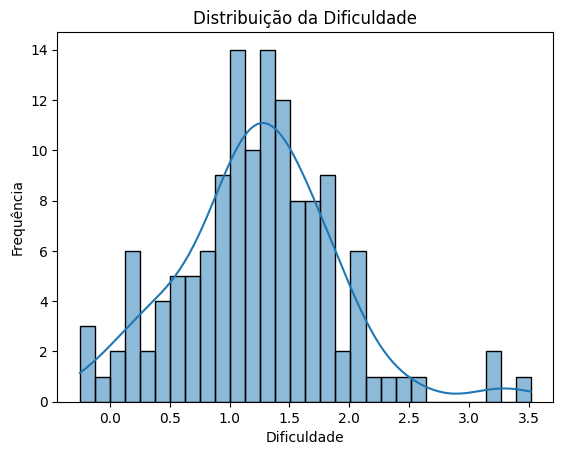

In [8]:
sns.histplot(df['dificuldade'], bins=30, kde=True)
plt.title('Distribuição da Dificuldade')
plt.xlabel('Dificuldade')
plt.ylabel('Frequência')

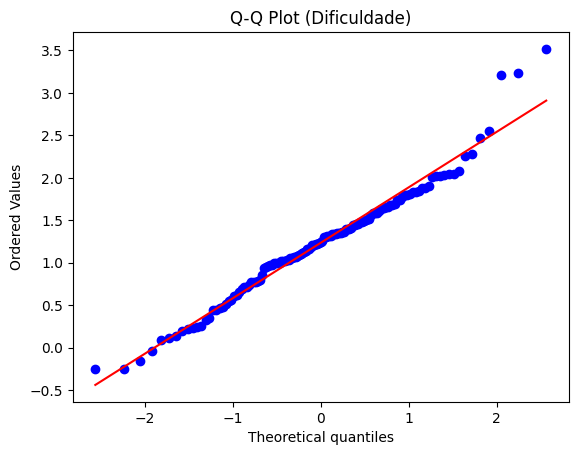

In [9]:
stats.probplot(df['dificuldade'], dist="norm", plot=plt)
plt.title('Q-Q Plot (Dificuldade)')
plt.show()

In [10]:
stat, p = stats.shapiro(df[df['dificuldade'].notna()]['dificuldade'])
print(f"Estatística de teste: {stat:.4f} | p-valor: {p:.4f}")

if p > 0.05:
    print("Não rejeita H_0: distribuição normal.")
else:
    print("Rejeita H_0: exclui distribuição normal.")


Estatística de teste: 0.9736 | p-valor: 0.0109
Rejeita H_0: exclui distribuição normal.


Com a exclusão da distribuição normal, necessário o grupo se atentar se o modelo de predição possui sensibilidade à distribuição. 

Caso seja, possível aplicar Box-Cox.

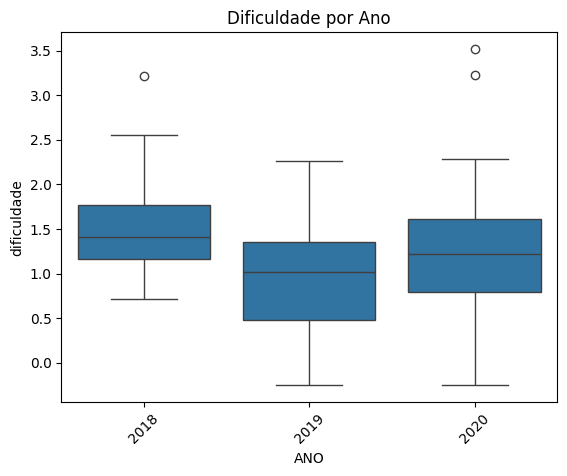

In [12]:
sns.boxplot(x='ANO', y='dificuldade', data=df, order=sorted(df["ANO"].unique()))
plt.title('Dificuldade por Ano')
plt.xticks(rotation=45)

plt.show()

In [13]:
def max_sem_outlier(group):
    Q1 = group.quantile(0.25)
    Q3 = group.quantile(0.75)
    IQR = Q3 - Q1
    limite_superior = Q3 + 1.5 * IQR
    return group[group <= limite_superior].max()  

max_por_ano = df.groupby('ANO')['dificuldade'].apply(max_sem_outlier)
max_por_ano

ANO
2018    2.55364
2019    2.25728
2020    2.28546
Name: dificuldade, dtype: float64

O corte de dificuldade 3, feito no artigo, não parece de todo arbitrário.

Afinal, na maioria dos anos, o máximo de dificuldade (excluídos os outliers) não ultrapassa 3 frequentemente. Como sugestão, possível utilizar o corte do máximo da lista (ano de 2013, com 3.38570)

# **Análise enunciados**

In [14]:
# Download stopwords (palavras de parada)
import re
import nltk
from nltk.corpus import stopwords
 
nltk.download('stopwords')
stop_words = set(stopwords.words('portuguese'))

def clean_text(text):
    """Processando texto de acordo com o Protocolo Primi (2021), citado no artigo"""
    if not isinstance(text, str):  # Garantir que texto é string
        return ""
    
    words = re.findall(r'\b[a-zA-Zà-úÀ-ÚüÜ]+\b', text.lower())  # 1. Dividir item em palavras
    words = [word for word in words if word not in stop_words]  # 2. Remover stopwords
    return " ".join(sorted(set(words)))  # 3. Remover palavras duplicadas

def clean_alternatives(alt_text):
    """Processa as alternativas mantendo as letras (A:, B:, etc.) e limpando o conteúdo."""
    if not isinstance(alt_text, str):
        return ""
    
    alternatives = re.split(r'(?=[A-E]: )', alt_text)  # Divide mantendo os identificadores
    cleaned_alts = []
    
    for alt in alternatives:
        if ": " in alt:
            key, value = alt.split(": ", 1)  # Separa a letra da alternativa do conteúdo
            cleaned_value = clean_text(value)  # Aplica limpeza somente no conteúdo
            cleaned_alts.append(f"{key}: {cleaned_value}")  # Mantém o formato original
    
    return "; ".join(cleaned_alts)  # Junta novamente as alternativas

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/alesouza/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [15]:
df["enunciado_limpo"] = df["QUESTOES"].apply(clean_text)
df["alternativas_limpo"] = df["ALTERNATIVAS"].apply(clean_alternatives)

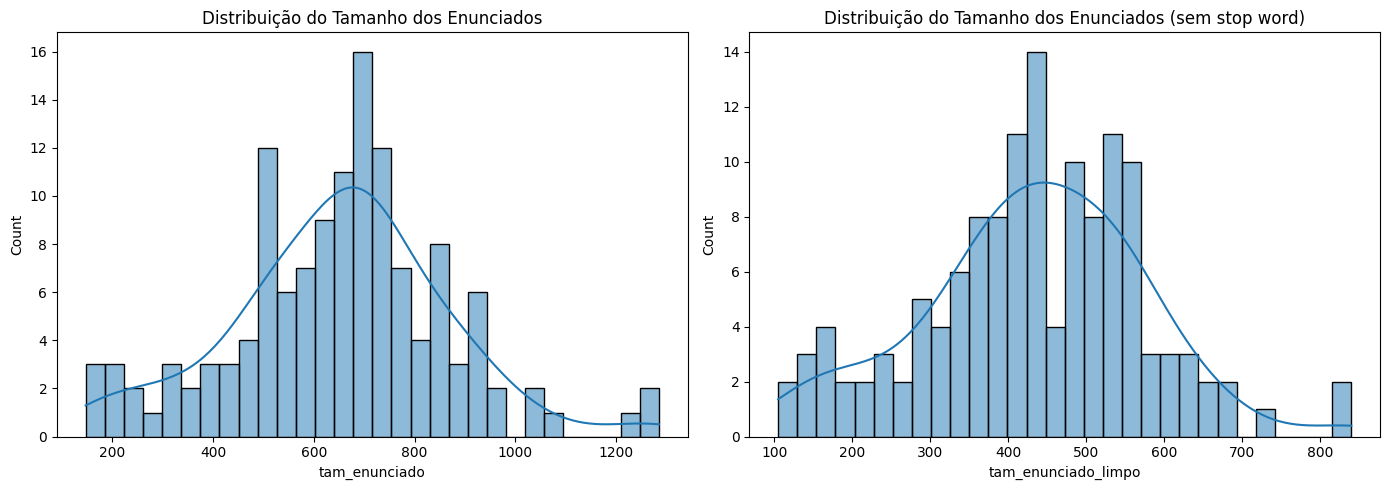

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
df['tam_enunciado'] = df['QUESTOES'].str.len()
df['tam_enunciado_limpo'] = df['enunciado_limpo'].str.len()

sns.histplot(df['tam_enunciado'], bins=30, kde=True, ax=axes[0])
axes[0].set_title('Distribuição do Tamanho dos Enunciados')

sns.histplot(df['tam_enunciado_limpo'], bins=30, kde=True, ax=axes[1])
axes[1].set_title('Distribuição do Tamanho dos Enunciados (sem stop word)')

plt.tight_layout()
plt.show()

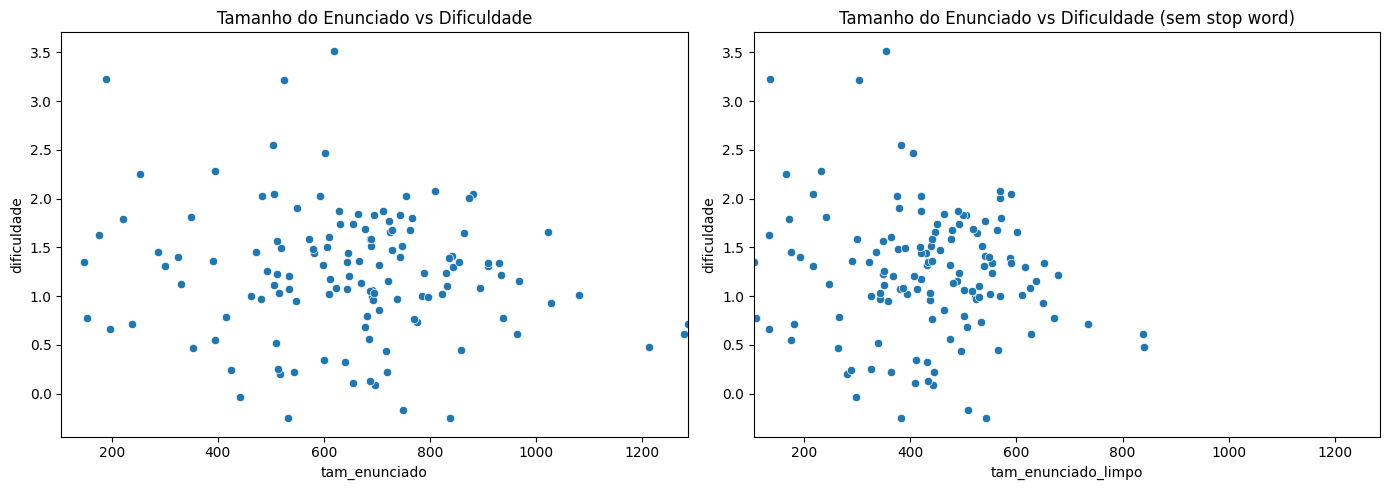

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.scatterplot(x='tam_enunciado', y='dificuldade', data=df, ax=axes[0])
axes[0].set_title('Tamanho do Enunciado vs Dificuldade')

sns.scatterplot(x='tam_enunciado_limpo', y='dificuldade', data=df, ax=axes[1])
axes[1].set_title('Tamanho do Enunciado vs Dificuldade (sem stop word)')

x_min = df['tam_enunciado_limpo'].min()
x_max = df['tam_enunciado'].max()
axes[0].set_xlim(x_min, x_max)
axes[1].set_xlim(x_min, x_max)

plt.tight_layout()
plt.show()

Não se verifica um correlação direta entre o tamanho do enunciado e a dificuldade da questão, muito embora se verifique uma pequena concentração entre 0 e 2 nos menores enunciados.

## **Análise de Gabarito**

<Axes: title={'center': 'Distribuição de Alternativas Corretas'}, xlabel='TX_GABARITO'>

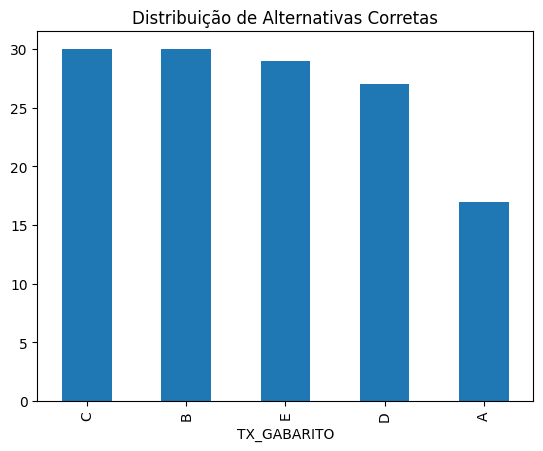

In [20]:
df['TX_GABARITO'].value_counts().plot(kind='bar', title='Distribuição de Alternativas Corretas')

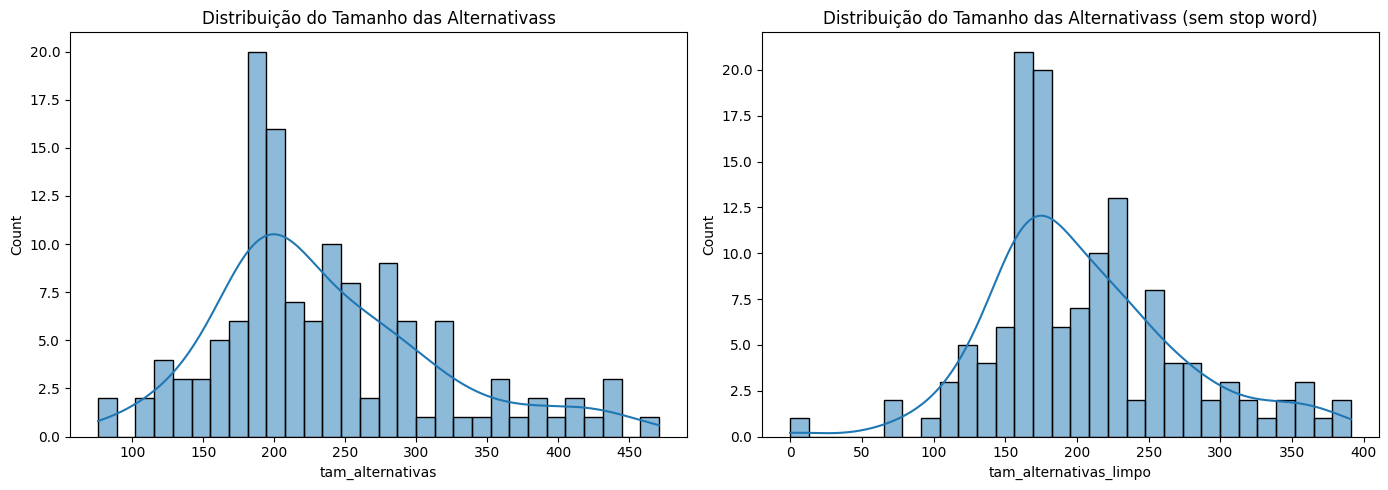

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
df['tam_alternativas'] = df['ALTERNATIVAS'].str.len()
df['tam_alternativas_limpo'] = df['alternativas_limpo'].str.len()

sns.histplot(df['tam_alternativas'], bins=30, kde=True, ax=axes[0])
axes[0].set_title('Distribuição do Tamanho das Alternativass')

sns.histplot(df['tam_alternativas_limpo'], bins=30, kde=True, ax=axes[1])
axes[1].set_title('Distribuição do Tamanho das Alternativass (sem stop word)')

plt.tight_layout()
plt.show()

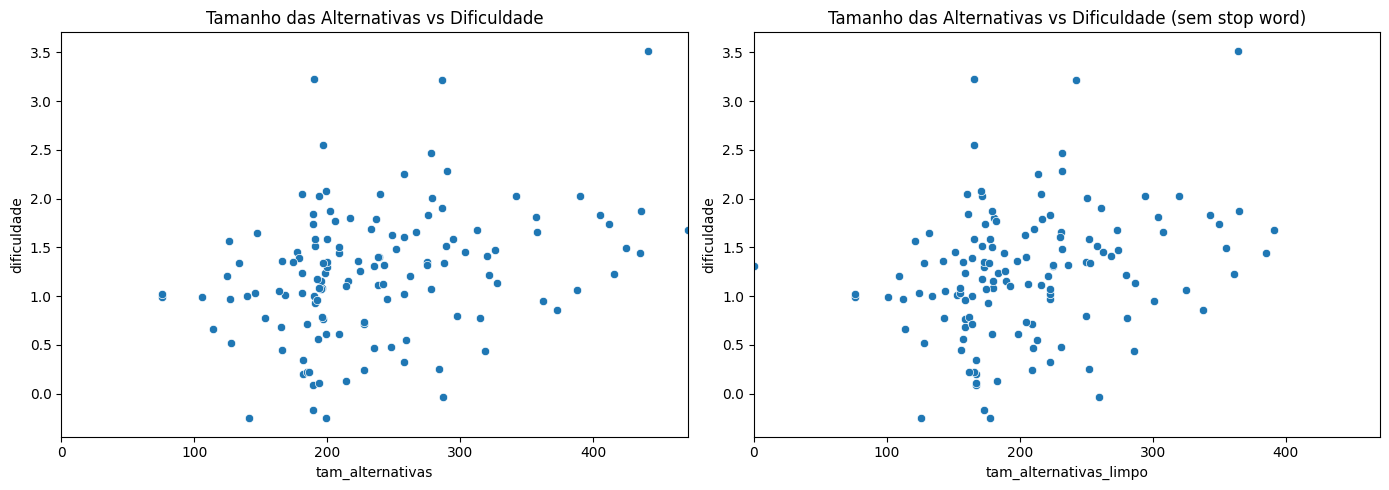

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.scatterplot(x='tam_alternativas', y='dificuldade', data=df, ax=axes[0])
axes[0].set_title('Tamanho das Alternativas vs Dificuldade')

sns.scatterplot(x='tam_alternativas_limpo', y='dificuldade', data=df, ax=axes[1])
axes[1].set_title('Tamanho das Alternativas vs Dificuldade (sem stop word)')

x_min = df['tam_alternativas_limpo'].min()
x_max = df['tam_alternativas'].max()
axes[0].set_xlim(x_min, x_max)
axes[1].set_xlim(x_min, x_max)

plt.tight_layout()
plt.show()

# WordCloud (Gabarito e Alternativas)

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

In [24]:
def get_wordcloud(df, col):
    # 1. Filtrar os dados
    df_counter = df.dropna(subset=[col])  # Remove NaN
    median_dif = df_counter['dificuldade'].median()

    # 2. Textos para cada grupo
    text_total = ' '.join(df_counter[col])
    text_hard = ' '.join(df_counter[df_counter['dificuldade'] > median_dif][col])
    text_easy = ' '.join(df_counter[df_counter['dificuldade'] <= median_dif][col])

    # 3. Configurar as nuvens
    wordcloud_total = WordCloud(width=600, height=300, background_color='white').generate(text_total)
    wordcloud_hard = WordCloud(width=600, height=300, background_color='white').generate(text_hard)
    wordcloud_easy = WordCloud(width=600, height=300, background_color='white').generate(text_easy)

    # 4. Plotar em uma linha
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Nuvem 1: Total
    axes[0].imshow(wordcloud_total, interpolation='bilinear')
    axes[0].set_title('Todos os Enunciados', fontsize=12)
    axes[0].axis('off')

    # Nuvem 2: Maior dificuldade
    axes[1].imshow(wordcloud_hard, interpolation='bilinear')
    axes[1].set_title(f'Maior Dificuldade ( > {median_dif:.2f})', fontsize=12)
    axes[1].axis('off')

    # Nuvem 3: Menor dificuldade
    axes[2].imshow(wordcloud_easy, interpolation='bilinear')
    axes[2].set_title(f'Menor Dificuldade ( ≤ {median_dif:.2f})', fontsize=12)
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

In [25]:
def get_word_frequencies(df, col, top_n = 10):
    # 1. Filtrar os dados
    df_counter = df.dropna(subset=[col])
    median_dif = df_counter['dificuldade'].median()

    # 2. Definir os grupos
    text_total = df_counter[col]
    text_hard = df_counter[df_counter['dificuldade'] > median_dif][col]
    text_easy = df_counter[df_counter['dificuldade'] <= median_dif][col]

    # 3. Contar palavras (top 10 em cada grupo)
    def get_top_words(text_series, n=top_n):
        vectorizer = CountVectorizer()
        X = vectorizer.fit_transform(text_series)
        word_counts = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out()).sum()
        return word_counts.sort_values(ascending=False).head(n)

    top_total = get_top_words(text_total)
    top_hard = get_top_words(text_hard)
    top_easy = get_top_words(text_easy)

    # 4. Plotar histogramas lado a lado
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

    # Histograma 1: Total
    axes[0].barh(top_total.index, top_total.values, color='skyblue')
    axes[0].set_title('Todos os Enunciados')
    axes[0].invert_yaxis()

    # Histograma 2: Alta dificuldade
    axes[1].barh(top_hard.index, top_hard.values, color='salmon')
    axes[1].set_title(f'Maior Dificuldade ( > {median_dif:.2f})')

    # Histograma 3: Baixa dificuldade
    axes[2].barh(top_easy.index, top_easy.values, color='lightgreen')
    axes[2].set_title(f'Menor Dificuldade ( ≤ {median_dif:.2f})')

    plt.tight_layout()
    plt.show()

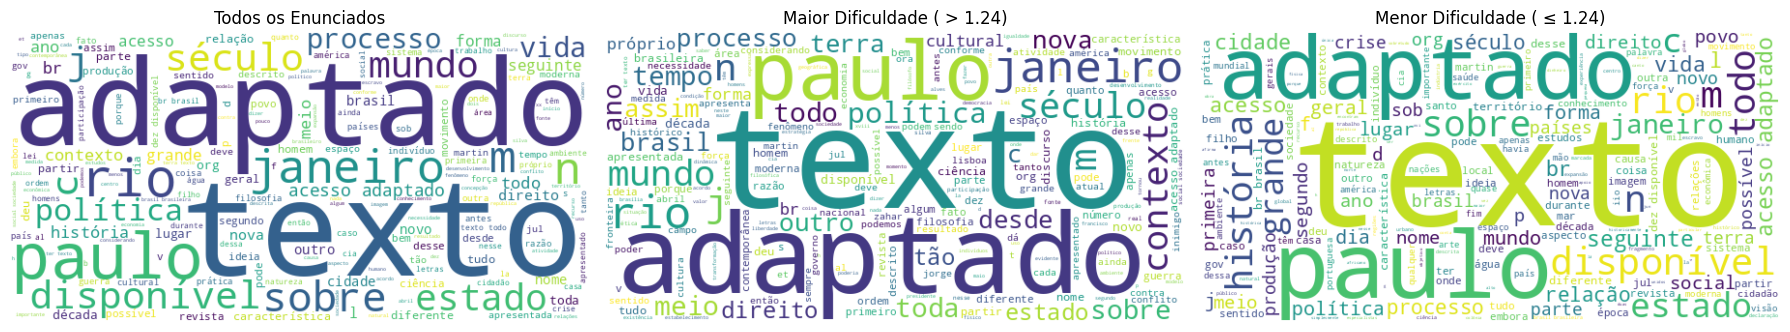

In [26]:
get_wordcloud(df, "enunciado_limpo")

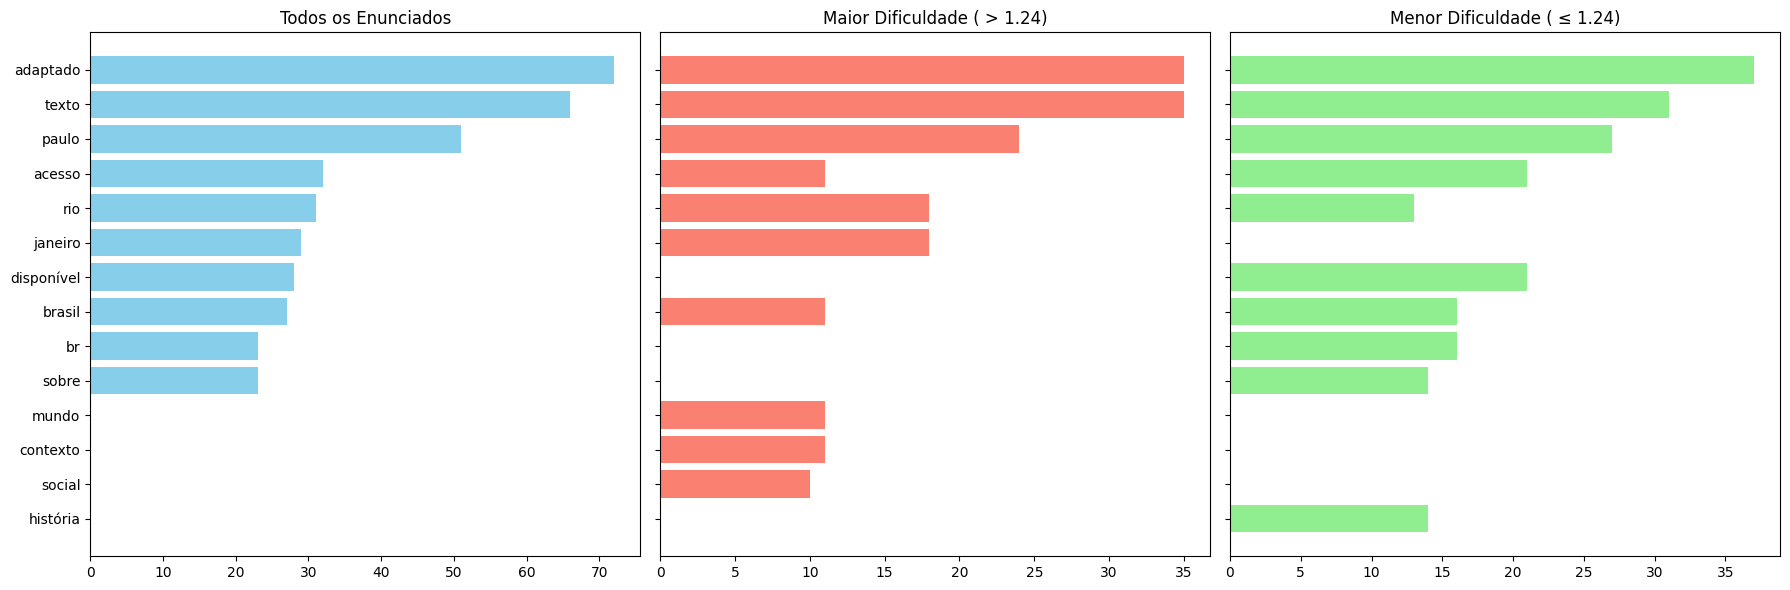

In [27]:
get_word_frequencies(df, "enunciado_limpo")

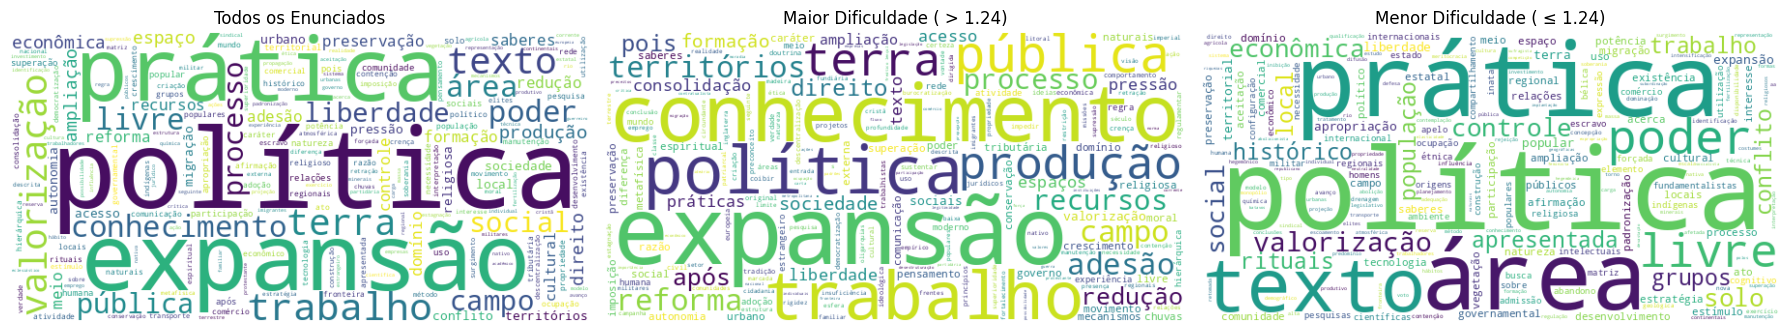

In [28]:
df['alternativas_adap'] = df['alternativas_limpo'].dropna().str.replace(r'[A-E]:\s*', '', regex=True)

get_wordcloud(df, "alternativas_adap")

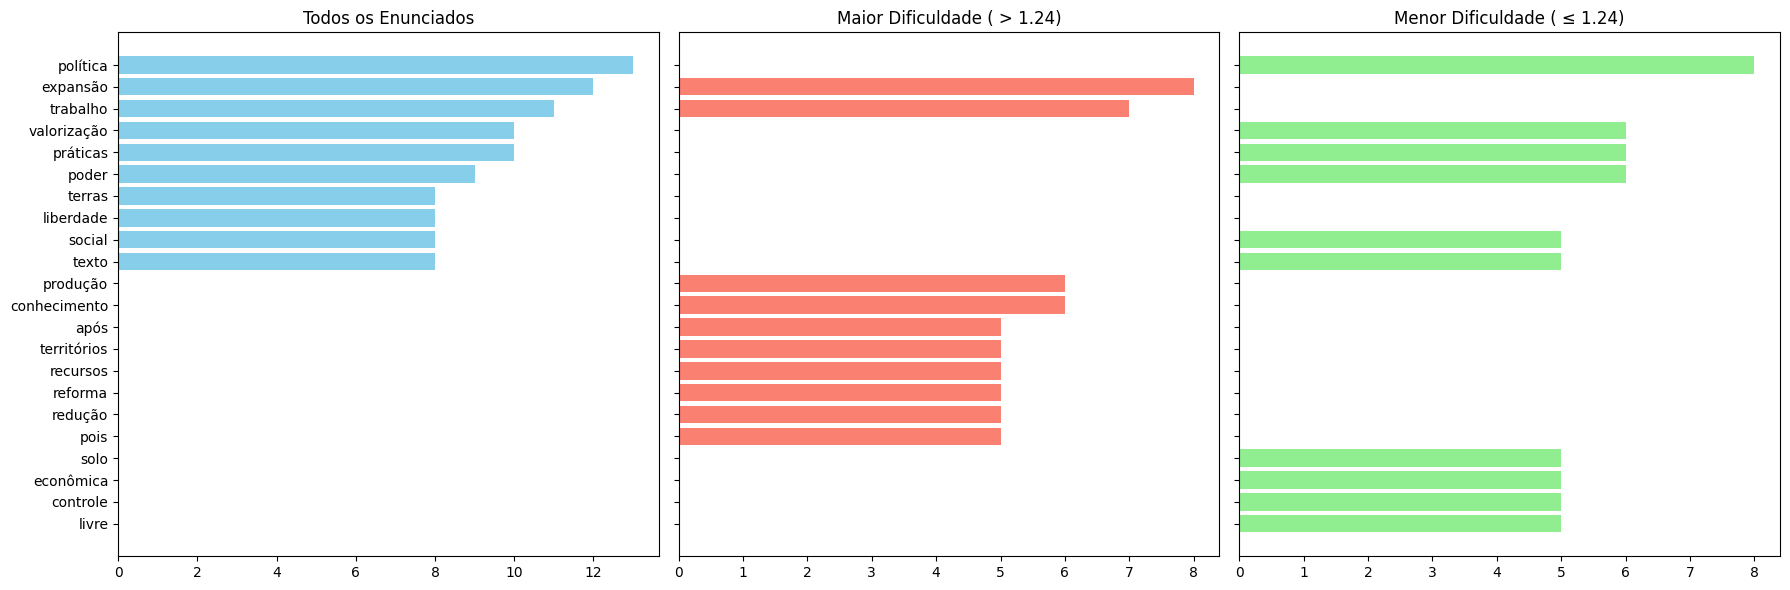

In [29]:
get_word_frequencies(df, "alternativas_adap")